Fare Bounds: (0, 22.25), Outliers: 16725
Distance Bounds: (1, 10.208951749999502), Outliers: 35119
Passenger Count Bounds: (1, 3.5), Outliers: 22766


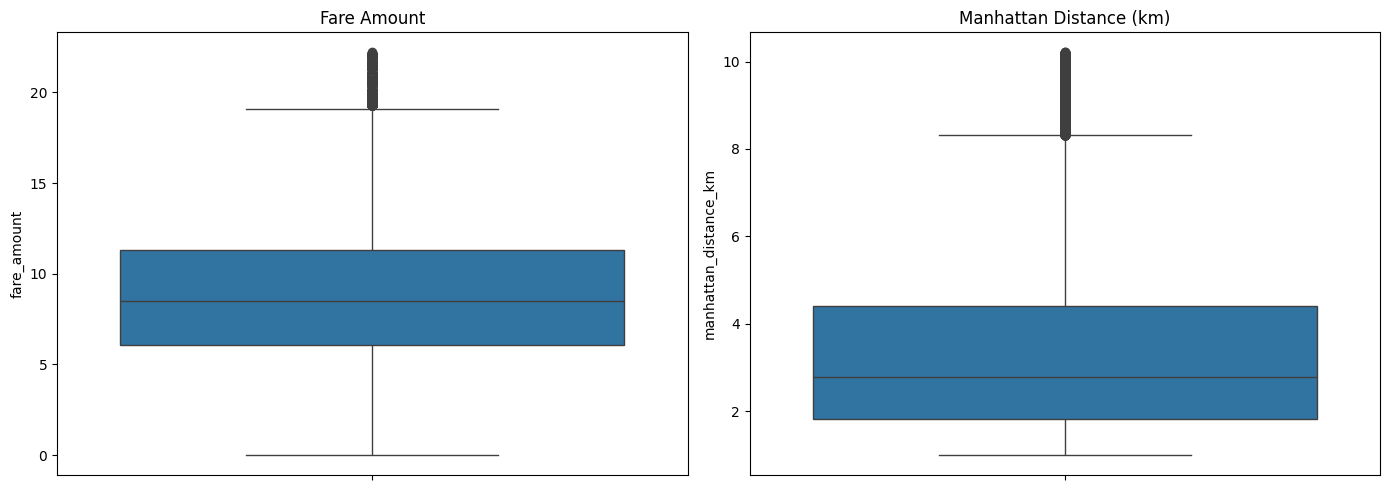

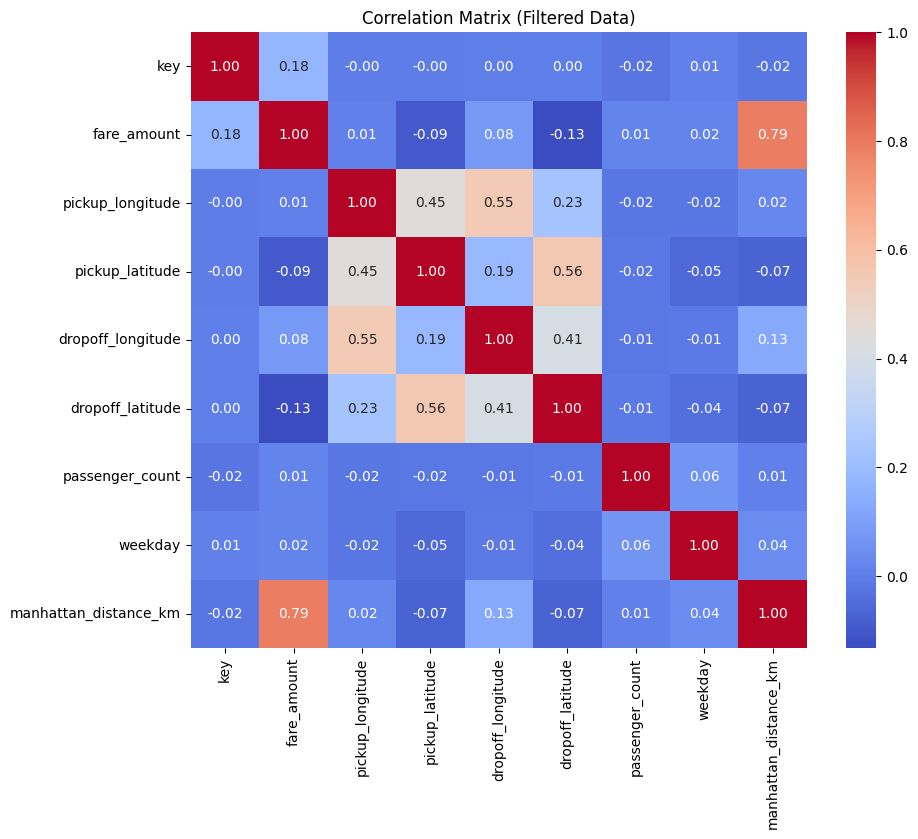

Linear Regression: R² = 0.62, RMSE = 2.39
Ridge: R² = 0.62, RMSE = 2.39
Lasso: R² = 0.62, RMSE = 2.39


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Load and inspect dataset
uber = pd.read_csv("./datasets/uber.csv").drop(columns=["Unnamed: 0", "pickup_datetime"])
uber.dropna(inplace=True)
uber["key"] = pd.to_datetime(uber["key"])
uber["weekday"] = uber["key"].dt.weekday

# Convert lat/long to Manhattan distance
lat_to_km, long_to_km = 111, 85  # km per degree
uber['manhattan_distance_km'] = ((uber['pickup_latitude'] - uber['dropoff_latitude']).abs() * lat_to_km + 
                                 (uber['pickup_longitude'] - uber['dropoff_longitude']).abs() * long_to_km)

# Filter to NYC coordinates
nyc_latitude_range, nyc_longitude_range = (40.5, 41.0), (-74.5, -73.5)
uber = uber[(uber['pickup_latitude'].between(*nyc_latitude_range)) & 
            (uber['pickup_longitude'].between(*nyc_longitude_range)) & 
            (uber['dropoff_latitude'].between(*nyc_latitude_range)) & 
            (uber['dropoff_longitude'].between(*nyc_longitude_range))]

# Detect outliers using IQR method
def get_outliers(df, column, lower_bound=0, upper_bound=None):
    Q1, Q3 = df[column].quantile(0.25), df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = max(Q1 - 1.5 * IQR, lower_bound)
    upper = min(Q3 + 1.5 * IQR, upper_bound) if upper_bound else Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return lower, upper, outliers

# Apply outlier detection
fare_lower, fare_upper, fare_outliers = get_outliers(uber, 'fare_amount', lower_bound=0)
dist_lower, dist_upper, dist_outliers = get_outliers(uber, 'manhattan_distance_km', lower_bound=1)
passenger_lower, passenger_upper, passenger_outliers = get_outliers(uber, 'passenger_count', lower_bound=1, upper_bound=6)

print(f"Fare Bounds: ({fare_lower}, {fare_upper}), Outliers: {fare_outliers.shape[0]}")
print(f"Distance Bounds: ({dist_lower}, {dist_upper}), Outliers: {dist_outliers.shape[0]}")
print(f"Passenger Count Bounds: ({passenger_lower}, {passenger_upper}), Outliers: {passenger_outliers.shape[0]}")

# Remove outliers
uber = uber[(uber['fare_amount'].between(fare_lower, fare_upper)) & 
            (uber['manhattan_distance_km'].between(dist_lower, dist_upper)) & 
            (uber['passenger_count'].between(passenger_lower, passenger_upper))]

# Visualize data with boxplots
def plot_boxplots(df):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.boxplot(data=df, y='fare_amount', ax=axes[0]).set(title='Fare Amount')
    sns.boxplot(data=df, y='manhattan_distance_km', ax=axes[1]).set(title='Manhattan Distance (km)')
    plt.tight_layout()
    plt.show()

plot_boxplots(uber)

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(uber.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Correlation Matrix (Filtered Data)')
plt.show()

# Prepare data for modeling
X, y = uber[['manhattan_distance_km']], uber['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1)
}

# Evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2, rmse = r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False)
    print(f"{name}: R² = {r2:.2f}, RMSE = {rmse:.2f}")
